In [4]:
using ITensors
using Random
using Plots
using QuadGK
using Roots
using StatsBase

In [5]:
s = siteinds("S=1/2", 25);
mps = randomMPS(ComplexF64, s; linkdims=4);

In [6]:
function get_probability_density(x::Float64, rdm::Matrix)
    """Takes in the 1-site reduced density matrix and 
    returns the probability of a given time series value, x 
    (note, x is before applying encoding, NOT ϕ(x))."""
    # convert time series value to encoded state by applying feature map
    # our complex feature map
    state = [exp(1im * (3π/2) * x) * cospi(0.5 * x), exp(-1im * (3π/2) * x) * sinpi(0.5 * x)]
    return abs(state' * rdm * state) # |<x|ρ|x>|
end

function get_normalisation_constant(rdm::Matrix)
    """Get the normalisation constant Z for the pdf"""
    prob_density_wrapper(x) = get_probability_density(x, rdm)
    norm_const, _ = quadgk(prob_density_wrapper, 0, 1) # integrate over data/x domain
    return norm_const
end

function get_cdf(x::Float64, rdm::Matrix, integral_norm_const::Float64)
    """Get the cumulative distribution function via numerical integration of
    the probability density function.

        Returns cdf evaluated at x where x is the proposed value i.e., F(x)."""

    prob_density_wrapper(x_prime) = (1/integral_norm_const) * get_probability_density(x_prime, rdm)

    cdf_val, _ = quadgk(prob_density_wrapper, 0, x) # pdf has support on the interval [0, 1] so integrate accordingly
    
    return cdf_val
end

function sample_state_from_rdm(rdm)
    """Given a 1 site RDM, samples a random value according to the
    conditional distribution encapsulated by the rdm using inverse transform sampling.
    Returns both the sampled value x (the un-feature mapped value) and the feature mapped
    value ϕ(x)."""
    norm_factor = get_normalisation_constant(rdm)
    u = rand() # sample a uniform random value from ~U(0,1)
    # solve for x by defining an auxilary function g(x) such that g(x) = F(x) - u and then use root finder to solve for x such that g(x) = 0
    cdf_wrapper(x) = get_cdf(x, rdm, norm_factor) - u
    sampled_x = find_zero(cdf_wrapper, (0, 1); rtol=0)
    # map sampled value back to a state
    sampled_state = [exp(1im * (3π/2) * sampled_x) * cospi(0.5 * sampled_x), exp(-1im * (3π/2) * sampled_x) * sinpi(0.5 * sampled_x)]
    
    return sampled_x, sampled_state

end

sample_state_from_rdm (generic function with 1 method)

In [110]:
function interpolate_time_ordered(label_mps::MPS, time_series::Vector{Float64}, interpolate_sites::Vector{Int})
    """Approach 1 - interpolate mps from start to finish, obeying time ordering.
    Takes the full (normalised) time series sample as input, as well as the indices of the sites to interpolate.
    Will treat the interpolation sites as `missing'."""

    # check that the length of the mps equals the sample length
    if length(label_mps) !== length(time_series)
        error("Time series length does not match MPS length.")
    end
    
    # check interpolation idxs exist

    mps = deepcopy(label_mps) # make a copy
    s = siteinds(mps)
    # put the mps into right canonical form - orthogonality center is set to the first site
    orthogonalize!(mps, 1)
    # create storage for samples
    x_samps = Vector{Float64}(undef, length(mps)) 

    # set A to the first MPS site
    A = mps[1]

    # loop through each site and determine whether to project or sample
    for i in eachindex(mps)
        # get the reduced density matrix at site i
        rdm = prime(A, s[i]) * dag(A)
        rdm_m = matrix(rdm) # convert to rdm

        if i in interpolate_sites
            #println("Sampling site $i from the reduced density matrix.")
            # sample a state from the rdm using inverse transform sampling
            sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
            x_samps[i] = sampled_x
            if i != length(mps)
                sampled_state_as_ITensor = ITensor(sampled_state, s[i])
                # get the probability of the state for normalising the next site
                proba_state = get_probability_density(sampled_x, rdm_m)
                #println("Prob of sampled state: $proba_state")
                # check that the trace of the rdm is equal to one
                sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
                # make the measurment of the site
                Am = A * dag(sampled_state_as_ITensor)
                # absorb into the next site
                A_new = mps[(i+1)] * Am
                # normalise by the probability
                A_new *= 1/sqrt(proba_state)
                # set A to A_new
                A = A_new
            end

        else
            # make a projective measurement using known value
            #println("Measuring site $i to be a known value: $(time_series[i]).")
            known_x = time_series[i]
            known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
            known_state_as_ITensor = ITensor(known_state, s[i])
            
            # make the measurment at the site
            Am = A * dag(known_state_as_ITensor)

            # absorb orthogonality center into the next site
            if i != length(mps)
                A_new = mps[(i+1)] * Am
                # normalise by the probability of the known state
                proba_state = get_probability_density(known_x, rdm_m)
                A_new *= 1/sqrt(proba_state)
                A = A_new
            end
            x_samps[i] = known_x
        end
    end

    return x_samps

end

interpolate_time_ordered (generic function with 1 method)

In [147]:
time_series = rand(25) # make a fake time series
interp_idxs = [5, 10, 15, 20]

4-element Vector{Int64}:
  5
 10
 15
 20

In [148]:
samps = Matrix{Float64}(undef, 1000, 25)
for i in 1:1000
    samps[i, :] = interpolate_time_ordered(mps, time_series, interp_idxs)
end

In [149]:
mean_ts = mean(samps, dims=1)
std_ts = std(samps, dims=1)

1×25 Matrix{Float64}:
 2.44371e-15  1.11078e-16  2.33263e-15  …  2.11048e-15  1.11078e-15

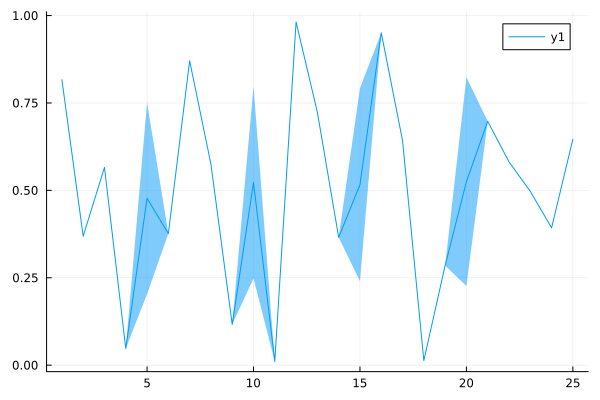

In [150]:
plot(mean_ts[1,:], ribbon=std_ts[1,:])

# Approach 2

In [233]:
s = siteinds("S=1/2", 6);
mps = randomMPS(ComplexF64, s; linkdims=4);

In [234]:
orthogonalize!(mps, 2)

MPS
[1] ((dim=2|id=268|"S=1/2,Site,n=1"), (dim=2|id=530|"Link,l=1"))
[2] ((dim=2|id=605|"S=1/2,Site,n=2"), (dim=4|id=744|"Link,l=2"), (dim=2|id=530|"Link,l=1"))
[3] ((dim=4|id=744|"Link,l=2"), (dim=2|id=374|"S=1/2,Site,n=3"), (dim=4|id=612|"Link,l=3"))
[4] ((dim=4|id=612|"Link,l=3"), (dim=2|id=878|"S=1/2,Site,n=4"), (dim=4|id=42|"Link,l=4"))
[5] ((dim=4|id=42|"Link,l=4"), (dim=2|id=792|"S=1/2,Site,n=5"), (dim=2|id=990|"Link,l=5"))
[6] ((dim=2|id=990|"Link,l=5"), (dim=2|id=498|"S=1/2,Site,n=6"))


In [235]:
A = mps[2];
rdm = prime(A, s[2]) * dag(A)
rdm_m = matrix(rdm) # convert to rdm

2×2 Matrix{ComplexF64}:
  0.397111-1.85151e-18im  -0.120561+0.204667im
 -0.120561-0.204667im      0.602889-1.82335e-18im

In [236]:
known_x = 0.3
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[2]);
Am = A * dag(known_state_as_ITensor)
A_new = mps[3] * Am

ITensor ord=3 (dim=2|id=374|"S=1/2,Site,n=3") (dim=4|id=612|"Link,l=3") (dim=2|id=530|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [237]:
proba_state = get_probability_density(known_x, rdm_m)

0.5834525318438778

In [238]:
A_new *= 1/sqrt(proba_state)

ITensor ord=3 (dim=2|id=374|"S=1/2,Site,n=3") (dim=4|id=612|"Link,l=3") (dim=2|id=530|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [239]:
norm(A_new)

1.0

In [240]:
MPS_after_s2 = MPS(5)

MPS
#undef
#undef
#undef
#undef
#undef


In [241]:
MPS_after_s2[1] = mps[1]
MPS_after_s2[2] = A_new
MPS_after_s2[3] = mps[4]
MPS_after_s2[4] = mps[5]
MPS_after_s2[5] = mps[6]

ITensor ord=2 (dim=2|id=990|"Link,l=5") (dim=2|id=498|"S=1/2,Site,n=6")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [242]:
norm(MPS_after_s2)

0.9999999999999999

Condition site 5 which is now at mps index 4

In [226]:
site_5_loc = findsite(MPS_after_s2, s[5])

4

In [227]:
orthogonalize!(MPS_after_s2, site_5_loc)

MPS
[1] ((dim=2|id=171|"S=1/2,Site,n=1"), (dim=2|id=19|"Link,l=1"))
[2] ((dim=2|id=175|"S=1/2,Site,n=3"), (dim=2|id=19|"Link,l=1"), (dim=4|id=332|"Link,l=3"))
[3] ((dim=2|id=177|"S=1/2,Site,n=4"), (dim=4|id=332|"Link,l=3"), (dim=4|id=585|"Link,l=4"))
[4] ((dim=2|id=110|"S=1/2,Site,n=5"), (dim=4|id=585|"Link,l=4"), (dim=2|id=787|"Link,l=5"))
[5] ((dim=2|id=734|"S=1/2,Site,n=6"), (dim=2|id=787|"Link,l=5"))


In [228]:
A = MPS_after_s2[site_5_loc];
rdm = prime(A, s[5]) * dag(A) # old s[5] is now s[4]
rdm_m = matrix(rdm) # convert to rdm

2×2 Matrix{ComplexF64}:
 0.554672+4.56775e-18im  0.212994-0.173207im
 0.212994+0.173207im     0.445328-1.57325e-18im

In [229]:
known_x = 0.9
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[5]);
Am = A * dag(known_state_as_ITensor)
A_new = MPS_after_s2[5] * Am

ITensor ord=2 (dim=2|id=734|"S=1/2,Site,n=6") (dim=4|id=585|"Link,l=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [230]:
proba_state = get_probability_density(known_x, rdm_m)

0.3660151423647971

In [231]:
A_new *= 1/sqrt(proba_state)

ITensor ord=2 (dim=2|id=734|"S=1/2,Site,n=6") (dim=4|id=585|"Link,l=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [232]:
norm(A_new)

0.9999999999999999

In [201]:
MPS_after_s5 = MPS(4)

MPS
#undef
#undef
#undef
#undef


In [202]:
MPS_after_s2

MPS
[1] ((dim=2|id=88|"S=1/2,Site,n=1"), (dim=2|id=0|"Link,l=1"))
[2] ((dim=2|id=286|"S=1/2,Site,n=3"), (dim=2|id=0|"Link,l=1"), (dim=4|id=51|"Link,l=3"))
[3] ((dim=2|id=161|"S=1/2,Site,n=4"), (dim=4|id=51|"Link,l=3"), (dim=4|id=523|"Link,l=4"))
[4] ((dim=2|id=986|"S=1/2,Site,n=5"), (dim=4|id=523|"Link,l=4"), (dim=2|id=320|"Link,l=5"))
[5] ((dim=2|id=919|"S=1/2,Site,n=6"), (dim=2|id=320|"Link,l=5"))


In [203]:
MPS_after_s5[1] = MPS_after_s2[1]
MPS_after_s5[2] = MPS_after_s2[2]
MPS_after_s5[3] = MPS_after_s2[3]
MPS_after_s5[4] = A_new

ITensor ord=2 (dim=2|id=919|"S=1/2,Site,n=6") (dim=4|id=523|"Link,l=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [204]:
MPS_after_s5

MPS
[1] ((dim=2|id=88|"S=1/2,Site,n=1"), (dim=2|id=0|"Link,l=1"))
[2] ((dim=2|id=286|"S=1/2,Site,n=3"), (dim=2|id=0|"Link,l=1"), (dim=4|id=51|"Link,l=3"))
[3] ((dim=2|id=161|"S=1/2,Site,n=4"), (dim=4|id=51|"Link,l=3"), (dim=4|id=523|"Link,l=4"))
[4] ((dim=2|id=919|"S=1/2,Site,n=6"), (dim=4|id=523|"Link,l=4"))


In [205]:
norm(MPS_after_s5)

1.0

Now sample from the remaining MPS

In [207]:
mps_conditioned = deepcopy(MPS_after_s5);

In [212]:
s = siteinds(mps_conditioned)

4-element Vector{Index{Int64}}:
 (dim=2|id=88|"S=1/2,Site,n=1")
 (dim=2|id=286|"S=1/2,Site,n=3")
 (dim=2|id=161|"S=1/2,Site,n=4")
 (dim=2|id=919|"S=1/2,Site,n=6")

In [209]:
orthogonalize!(mps_conditioned, 1);

In [223]:
A = mps_conditioned[1];
rdm = prime(A, s[1]) * dag(A);
rdm_m = matrix(rdm);
sampled_x, sampled_state = sample_state_from_rdm(rdm_m);
println(sampled_x)
sampled_state_as_ITensor = ITensor(sampled_state, s[1]);
proba_state = get_probability_density(sampled_x, rdm_m);
Am = A * dag(sampled_state_as_ITensor)
A_new = mps_conditioned[2] * Am
A_new *= 1/sqrt(proba_state)
A = A_new

0.6142836626106772


ITensor ord=2 (dim=2|id=286|"S=1/2,Site,n=3") (dim=4|id=875|"Link,l=3")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [225]:
rdm = prime(A, s[2]) * dag(A);
rdm_m = matrix(rdm);
sampled_x, sampled_state = sample_state_from_rdm(rdm_m);
println(sampled_x)
sampled_state_as_ITensor = ITensor(sampled_state, s[2]);
proba_state = get_probability_density(sampled_x, rdm_m);
Am = A * dag(sampled_state_as_ITensor)
A_new = mps_conditioned[3] * Am
A_new *= 1/sqrt(proba_state)
A = A_new

0.9759395949990134


ITensor ord=2 (dim=2|id=161|"S=1/2,Site,n=4") (dim=2|id=873|"Link,l=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [226]:
rdm = prime(A, s[3]) * dag(A);
rdm_m = matrix(rdm);
sampled_x, sampled_state = sample_state_from_rdm(rdm_m);
println(sampled_x)
sampled_state_as_ITensor = ITensor(sampled_state, s[3]);
proba_state = get_probability_density(sampled_x, rdm_m);
Am = A * dag(sampled_state_as_ITensor)
A_new = mps_conditioned[4] * Am
A_new *= 1/sqrt(proba_state)
A = A_new

0.8198966792109809


ITensor ord=1 (dim=2|id=919|"S=1/2,Site,n=6")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [228]:
rdm = prime(A, s[4]) * dag(A);
rdm_m = matrix(rdm);
sampled_x, sampled_state = sample_state_from_rdm(rdm_m);
println(sampled_x)
sampled_state_as_ITensor = ITensor(sampled_state, s[4]);

0.06587761063661192


In [236]:
known_sites = [1, 4, 5]
s_test = siteinds("S=1/2", 100)
mps_test = randomMPS(ComplexF64, s_test; linkdims=4);
for i in eachindex(mps_test)
    if i ∉ known_sites
        println(i)
    end
end

2
3
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [10]:
s = siteinds("S=1/2", 5);

In [40]:
mps_new_test = randomMPS(s; linkdims=4);
ts = rand(5);
interp_sites = [4]

1-element Vector{Int64}:
 4

In [13]:
mps_new_test

MPS
[1] ((dim=2|id=874|"S=1/2,Site,n=1"), (dim=4|id=523|"Link,l=1"))
[2] ((dim=4|id=523|"Link,l=1"), (dim=2|id=320|"S=1/2,Site,n=2"), (dim=4|id=306|"Link,l=2"))
[3] ((dim=4|id=306|"Link,l=2"), (dim=2|id=999|"S=1/2,Site,n=3"), (dim=4|id=796|"Link,l=3"))
[4] ((dim=4|id=796|"Link,l=3"), (dim=2|id=931|"S=1/2,Site,n=4"), (dim=2|id=538|"Link,l=4"))
[5] ((dim=2|id=538|"Link,l=4"), (dim=2|id=90|"S=1/2,Site,n=5"))


In [15]:
orthogonalize!(mps_new_test, 1)

MPS
[1] ((dim=2|id=874|"S=1/2,Site,n=1"), (dim=4|id=523|"Link,l=1"))
[2] ((dim=4|id=523|"Link,l=1"), (dim=2|id=320|"S=1/2,Site,n=2"), (dim=4|id=306|"Link,l=2"))
[3] ((dim=4|id=306|"Link,l=2"), (dim=2|id=999|"S=1/2,Site,n=3"), (dim=4|id=796|"Link,l=3"))
[4] ((dim=4|id=796|"Link,l=3"), (dim=2|id=931|"S=1/2,Site,n=4"), (dim=2|id=538|"Link,l=4"))
[5] ((dim=2|id=538|"Link,l=4"), (dim=2|id=90|"S=1/2,Site,n=5"))


In [17]:
A = mps_new_test[1]
rdm = prime(A, s[1]) * dag(A)

ITensor ord=2 (dim=2|id=874|"S=1/2,Site,n=1")' (dim=2|id=874|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

In [19]:
known_x = 0.3
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[1]);
Am = A * dag(known_state_as_ITensor)

ITensor ord=1 (dim=4|id=523|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [22]:
proba_state = get_probability_density(known_x, matrix(rdm))
Am *= 1/sqrt(proba_state)

ITensor ord=1 (dim=4|id=523|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [27]:
mps_new_test[1] *= dag(known_state_as_ITensor)

ITensor ord=1 (dim=4|id=523|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [28]:
mps_new_test[1] *= 1/sqrt(proba_state)

ITensor ord=1 (dim=4|id=523|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [31]:
mps_new_test[2] *= mps_new_test[1]

ITensor ord=2 (dim=2|id=320|"S=1/2,Site,n=2") (dim=4|id=306|"Link,l=2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [37]:
mps_updated = MPS(mps_new_test[2:5])

MPS
[1] ((dim=2|id=320|"S=1/2,Site,n=2"), (dim=4|id=306|"Link,l=2"))
[2] ((dim=4|id=306|"Link,l=2"), (dim=2|id=999|"S=1/2,Site,n=3"), (dim=4|id=796|"Link,l=3"))
[3] ((dim=4|id=796|"Link,l=3"), (dim=2|id=931|"S=1/2,Site,n=4"), (dim=2|id=538|"Link,l=4"))
[4] ((dim=2|id=538|"Link,l=4"), (dim=2|id=90|"S=1/2,Site,n=5"))


In [267]:
function interpolate_non_sequential(label_mps::MPS, time_series::Vector{Float64}, 
    interpolate_sites::Vector{Int})

    # pre-condition MPS on all known sites
    mps = deepcopy(label_mps)
    s = siteinds(mps)
    known_sites = setdiff(collect(1:length(mps)), interpolate_sites)

    x_samps = Vector{Float64}(undef, length(mps))

    for i in 1:length(mps)
        if i in known_sites
            # value is known
            known_x = time_series[i]
            x_samps[i] = known_x
            # contract known site with mps
            orthogonalize!(mps, i)
            A = mps[i]
            rdm = prime(A, s[i]) * dag(A)
            rdm_m = matrix(rdm) # convert to rdm
            known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
            known_state_as_ITensor = ITensor(known_state, s[i]);
            Am = A * dag(known_state_as_ITensor)
            A_new = mps[(i+1)] * Am
            proba_state = get_probability_density(known_x, rdm_m)
            A_new *= 1/sqrt(proba_state)
            new_mps_length = length(mps) - 1
            mps_after_measurement = MPS(new_mps_length)
            for j in eachindex(mps_after_measurement)
                # re-assign sites
                if j < i
                    # direct copy over
                    mps_after_measurement[j] = mps[j]
                elseif j == i
                    mps_after_measurement[j] = A_new
                else
                    mps_after_measurement[j] = mps[(j+1)]
                end
            end

            mps = mps_after_measurement
            s = siteinds(mps)

        end

    end

end

interpolate_non_sequential (generic function with 1 method)

In [149]:
function interpolate_non_sequential2(label_mps::MPS, time_series::Vector{Float64},
    interpolate_sites::Vector{Int})
    # pre-condition MPS on all known sites
    mps = deepcopy(label_mps)
    s = siteinds(mps)
    known_sites = setdiff(collect(1:length(mps)), interpolate_sites)
    x_samps = Vector{Float64}(undef, length(mps))

    # part 1 - condition MPS on known values using MPOs
    for i in eachindex(mps)
        if i in known_sites
            # value is known
            x = time_series[i]
            state = [exp(1im * (3π/2) * x) * cospi(0.5 * x), exp(-1im * (3π/2) * x) * sinpi(0.5 * x)]
            # make projector
            projector = state * state'
            # check properties
            if !isapprox(tr(projector), 1.0) @warn "tr(|x⟩⟨x| != 1 @ site $i)" end
            println(projector)
            # convert into single site MPO at site id
            println("Making projector operator @ site $i")
            proj_op = op(projector, s, i)            
            # apply projector to the mps
            mps_projected = apply(proj_op, mps)
            normalize!(mps_projected) # should be fine, if not, need to normalise by 1/sqrt(prob) of state
            # done, proceed to next known site
            mps = mps_projected            
        end
    end

    # part 2 - interpolate unknown sites
    orthogonalize!(mps, 1) # put mps into right canonical form and start at site 1
    s = siteinds(mps)
    A = mps[1]
    ps = []
    for i in eachindex(mps)
        # determine whether site is known
        rdm = prime(A, s[i]) * dag(A)
        rdm_m = matrix(rdm) # convert to rdm
        println("TR @ site $i: $(tr(rdm_m))")
        if i in known_sites
            # site is known 
            known_x = time_series[i]
            known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
            known_state_as_ITensor = ITensor(known_state, s[i])
            # make the measurment at the site
            Am = A * dag(known_state_as_ITensor)
            if i != length(mps)
                A_new = mps[(i+1)] * Am
                # normalise by the probability of the known state
                proba_state = get_probability_density(known_x, rdm_m)
                #println("Probability of known state: $proba_state")
                A_new *= 1/sqrt(proba_state)
                A = A_new
            end
            x_samps[i] = known_x
        else
            # site is unkown - interpolate
            println("Interpolating site $i")
            sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
            x_samps[i] = sampled_x
            if i != length(mps)
                sampled_state_as_ITensor = ITensor(sampled_state, s[i])
                # get the probability of the state for normalising the next site
                proba_state = get_probability_density(sampled_x, rdm_m)
                #println("Prob of sampled state: $proba_state")
                # check that the trace of the rdm is equal to one
                #sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
                # make the measurment of the site
                Am = A * dag(sampled_state_as_ITensor)
                # absorb into the next site
                A_new = mps[(i+1)] * Am
                # normalise by the probability
                A_new *= 1/sqrt(proba_state)
                # set A to A_new
                A = A_new
            end
        end
    end

    return x_samps
    
end

interpolate_non_sequential2 (generic function with 1 method)

In [117]:
s = siteinds("S=1/2", 50)
mps_new_test = randomMPS(s; linkdims=4);
ts = rand(50);

In [122]:
interp_sites = collect(20:1:30)

11-element Vector{Int64}:
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30

In [147]:
interpolate_non_sequential2(mps_new_test, ts, interp_sites)

50-element Vector{Float64}:
 0.6746844142666839
 0.02147376988379457
 0.15654934824068878
 0.17789252764813746
 0.7878583103004093
 0.2739255029462173
 0.12539014480851263
 0.02918549924777325
 0.1372157835843918
 0.2261585917758876
 ⋮
 0.8445966465450395
 0.7506204876543182
 0.4121729491103244
 0.7213926229541072
 0.7797568111917544
 0.8677835867891348
 0.6699770280004347
 0.10075500661532355
 0.2638732929941714

In [127]:
outs_all = Matrix{Float64}(undef, 1000, 50);
for i in 1:1000
    outs_all[i, :] = interpolate_non_sequential2(mps_new_test, ts, interp_sites)
end

InterruptException: InterruptException:

In [125]:
mean_ts = mean(outs_all, dims=1)[1,:]
std_ts = std(outs_all, dims=1)[1,:]

50-element Vector{Float64}:
 4.443114211273408e-16
 1.3537613612473663e-16
 6.664671316910112e-16
 3.8877249348642313e-16
 1.5550899739456925e-15
 6.664671316910112e-16
 3.610030296659644e-16
 1.0413548932672049e-16
 5.55389276409176e-17
 9.44161769895599e-16
 ⋮
 3.110179947891385e-15
 1.3329342633820224e-15
 2.7769463820458796e-16
 3.3323356584550558e-15
 3.2212578031732204e-15
 2.7769463820458797e-15
 2.443712816200374e-15
 3.8877249348642313e-16
 1.1663174804592695e-15

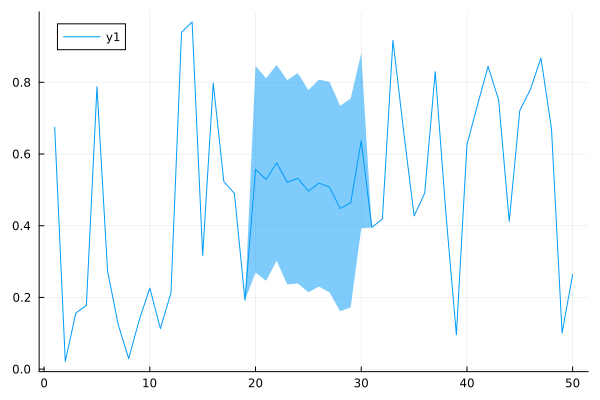

In [126]:
plot(mean_ts, ribbon=std_ts)

----

# Attempt 3 - 5 sites

In [209]:
s_og = siteinds("S=1/2", 5); # original indices
ts = rand(5)
mps = randomMPS(ComplexF64, s_og; linkdims=4);
interp_sites = [3, 4];
mps_length = length(mps);

In [210]:
mps
orthogonalize!(mps, 1)
A = mps[1];

In [211]:
rdm = prime(A, s_og[1]) * dag(A)
rdm_m = matrix(rdm)

2×2 Matrix{ComplexF64}:
 0.690517-5.55168e-18im  0.151165+0.106317im
 0.151165-0.106317im     0.309483-2.71718e-18im

In [212]:
x1 = ts[1]
known_state = [exp(1im * (3π/2) * x1) * cospi(0.5 * x1), exp(-1im * (3π/2) * x1) * sinpi(0.5 * x1)]
known_state_as_ITensor = ITensor(known_state, s_og[1])
# make measurement at the site
Am = A * dag(known_state_as_ITensor)
A_new = mps[2] * Am
proba_state = get_probability_density(known_x, rdm_m)
Am *= 1/sqrt(proba_state)

ITensor ord=1 (dim=4|id=889|"Link,l=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [213]:
norm(Am)

0.9239662159166782

In [203]:
mps[2] *= Am

ITensor ord=2 (dim=2|id=799|"S=1/2,Site,n=2") (dim=4|id=58|"Link,l=2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

Make new mps

In [204]:
mps_after_1 = MPS(mps[2:end])

MPS
[1] ((dim=2|id=799|"S=1/2,Site,n=2"), (dim=4|id=58|"Link,l=2"))
[2] ((dim=4|id=58|"Link,l=2"), (dim=2|id=739|"S=1/2,Site,n=3"), (dim=4|id=813|"Link,l=3"))
[3] ((dim=4|id=813|"Link,l=3"), (dim=2|id=375|"S=1/2,Site,n=4"), (dim=2|id=222|"Link,l=4"))
[4] ((dim=2|id=222|"Link,l=4"), (dim=2|id=738|"S=1/2,Site,n=5"))


In [205]:
norm(mps_after_1)

1.1279500737712607

In [ ]:
for i in 1:mps_length
    s_current = siteinds(mps) # keep track of changing s since mps shrinks
    A = mps[i]
    if i ∉ interp_sites
        println("Measuring site $i")
        # find correct location in mps for original site index
        mps_loc = findsite(mps, s_og[i]) # mps changes length
        # put into right canonical form
        orthogonalize!(mps, mps_loc)
        # get rdm
        rdm = prime(A, s_current[i]) * dag(A)
        rdm_m = matrix(rdm)
        known_x = ts[i]
        known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
        known_state_as_ITensor = ITensor(known_state, s[i])
        # make measurement at the site
        Am = A * dag(known_state_as_ITensor)
        # if not last site, absorb into neighbour

        if i != length(mps)
            A_new = mps[(i+1)] * Am
            # normalise by the probability of the known state
            proba_state = get_probability_density(known_x, rdm_m)
            A_new *= 1/sqrt(proba_state)
            A = A_new
        end

        # make a new mps with A as the first site
        mps_new = MPS((length(mps) - 1))
        mps_new[1] = A_new

    else
        println("Skipping site $i")
    end
end

In [173]:
findsite(mps, s_og[1])

1

In [160]:
orthogonalize!(mps, 1);

In [ ]:
A = mps[1]
known_x = 0.9
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[1]);
Am = A * dag(known_state_as_ITensor)
A_new = MPS_after_s2[5] * Am